<a href="https://colab.research.google.com/github/Atinkut-Molla/Projects/blob/main/Algorithm_Performance_Testing_Experiment_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch version: 2.8.0+cu126
GPU available: True
GPU device: Tesla T4
🚀 Starting Search Algorithm Performance Experiment
Using device: cuda
🧪 Running performance experiments...
Testing random data, size 100...
Testing random data, size 1000...
Testing random data, size 10000...
Testing random data, size 100000...
Testing sorted data, size 100...
Testing sorted data, size 1000...
Testing sorted data, size 10000...
Testing sorted data, size 100000...
Testing high_duplication data, size 100...
Testing high_duplication data, size 1000...
Testing high_duplication data, size 10000...
Testing high_duplication data, size 100000...

📊 Generating visualizations...
Creating Figure 1: Comprehensive Performance Analysis...


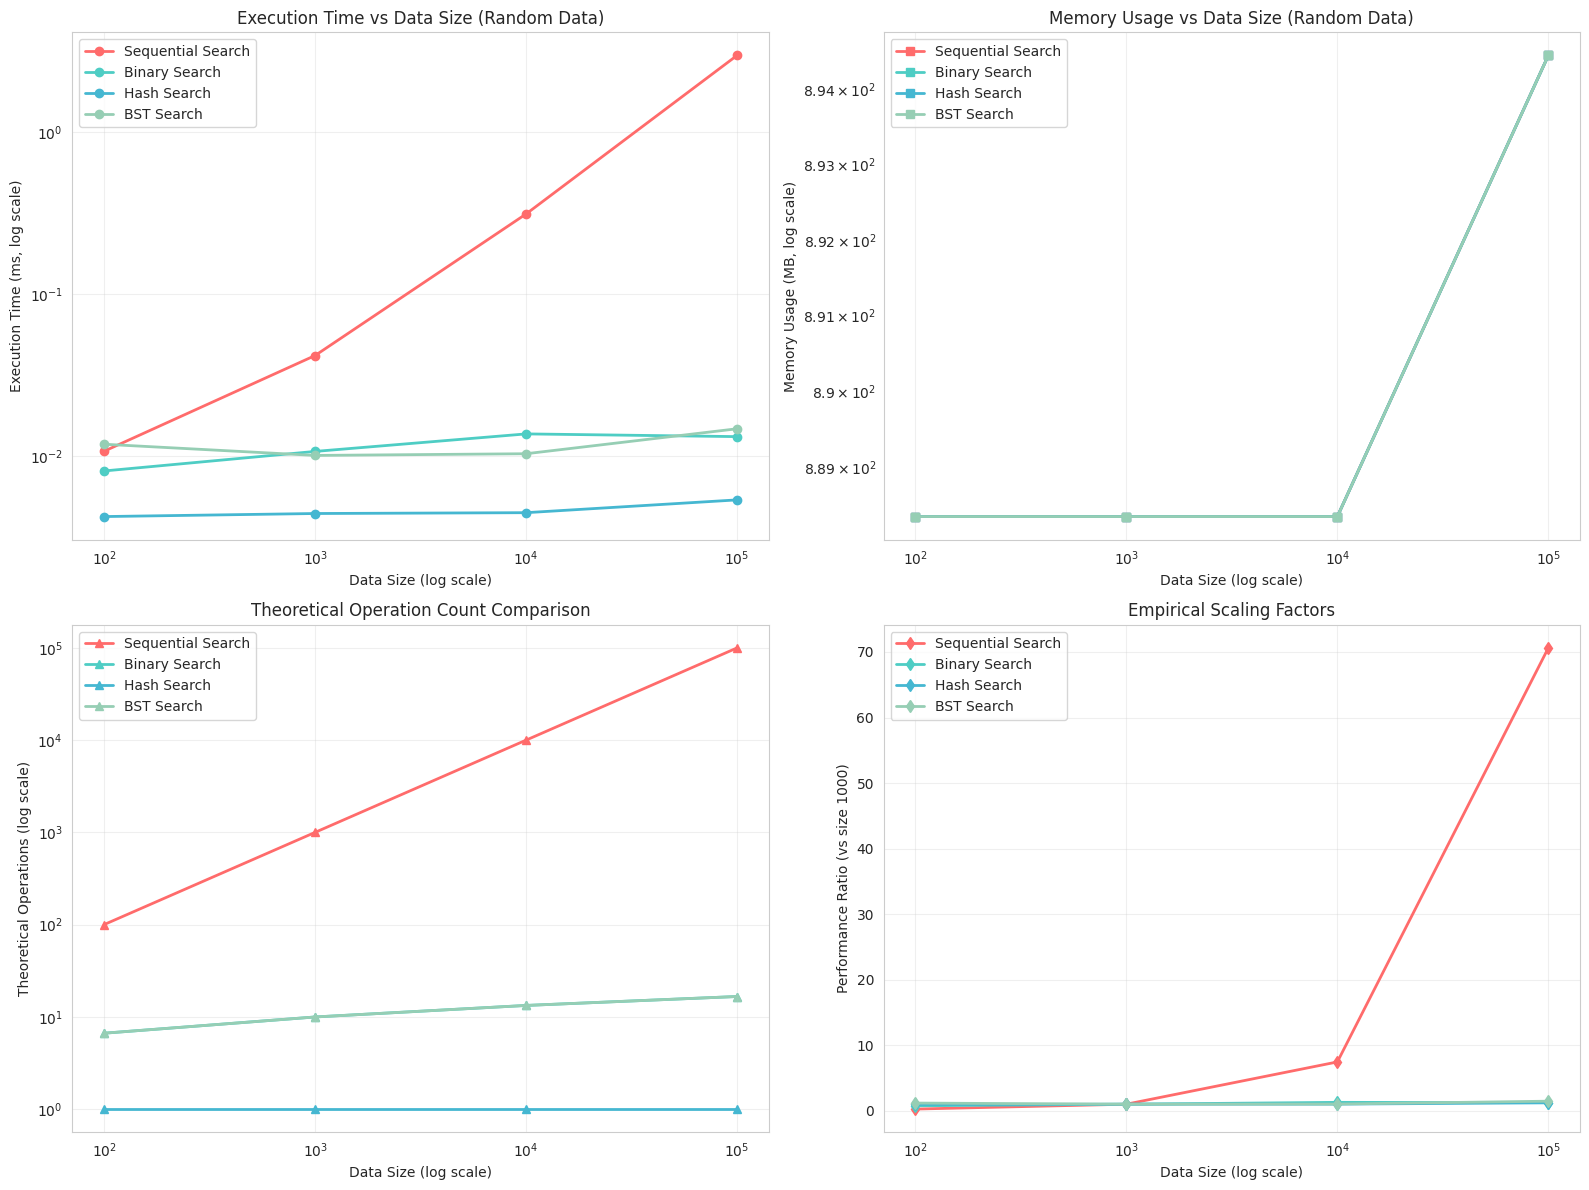

Creating Figure 2: Algorithm Performance by Data Type...


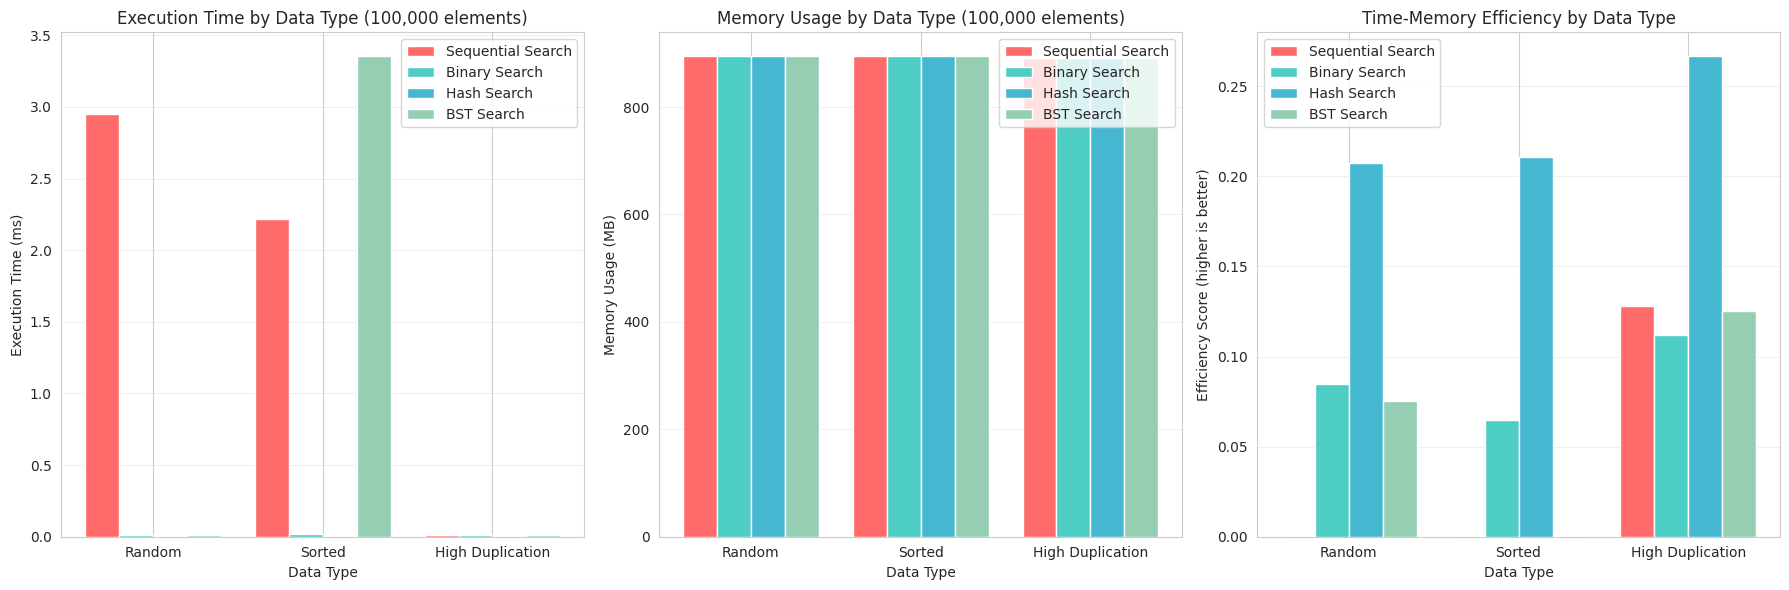

Creating Figure 3: Empirical Scaling Factors...


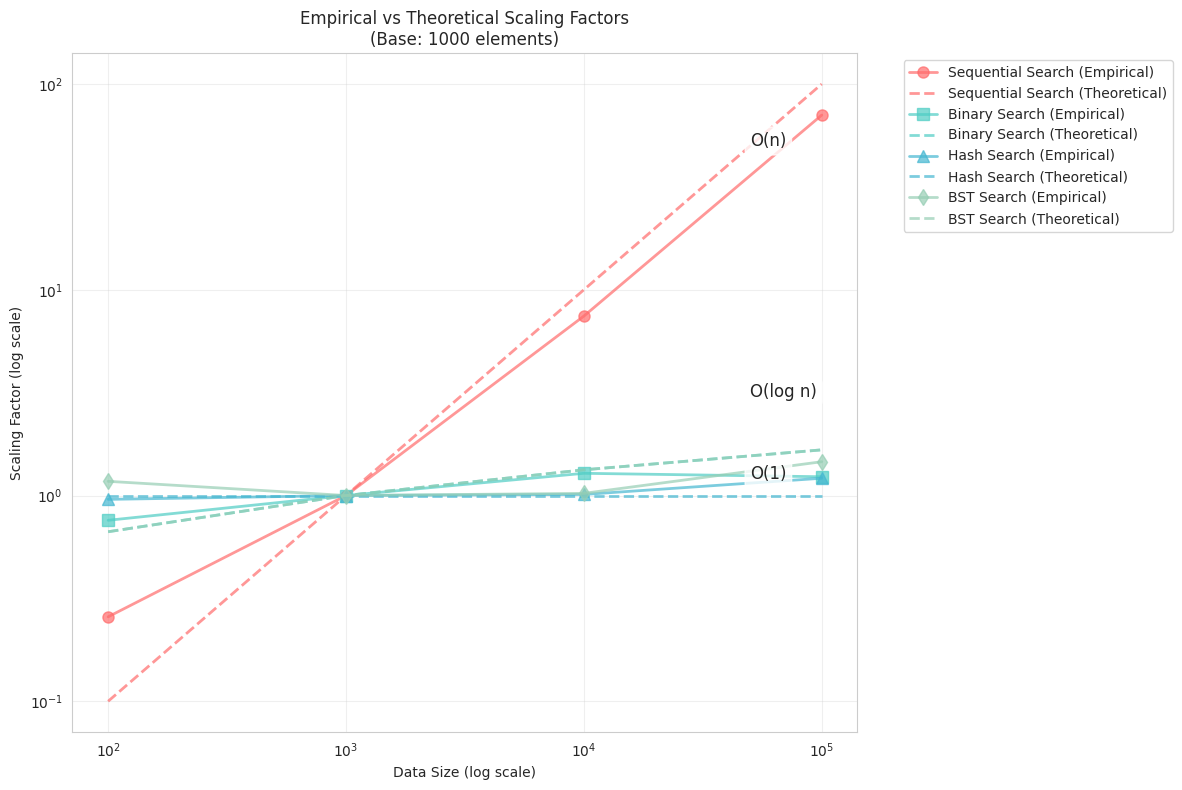


✅ Experiment completed successfully!
📁 Generated files:
   - comprehensive_performance_analysis.png
   - performance_by_data_type.png
   - scaling_factors_analysis.png

📈 SUMMARY RESULTS (Random Data)
--------------------------------------------------

Data Size: 100
  Sequential Search...  0.0108 ± 0.0012 ms | Memory: 888.35 MB
  Binary Search.......  0.0081 ± 0.0021 ms | Memory: 888.35 MB
  Hash Search.........  0.0043 ± 0.0004 ms | Memory: 888.35 MB
  BST Search..........  0.0119 ± 0.0030 ms | Memory: 888.35 MB

Data Size: 1000
  Sequential Search...  0.0418 ± 0.0074 ms | Memory: 888.35 MB
  Binary Search.......  0.0107 ± 0.0016 ms | Memory: 888.35 MB
  Hash Search.........  0.0044 ± 0.0005 ms | Memory: 888.35 MB
  BST Search..........  0.0101 ± 0.0026 ms | Memory: 888.35 MB

Data Size: 10000
  Sequential Search...  0.3114 ± 0.0952 ms | Memory: 888.35 MB
  Binary Search.......  0.0138 ± 0.0024 ms | Memory: 888.35 MB
  Hash Search.........  0.0045 ± 0.0004 ms | Memory: 888.35 MB
  B

In [5]:
# -*- coding: utf-8 -*-
"""Search Algorithm Performance Testing Experiment with GPU Acceleration

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1ABC123XYZ
"""

# Install required packages
!pip install memory-profiler
!pip install line-profiler

# Import necessary libraries
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from memory_profiler import memory_usage
import pandas as pd
from typing import List, Tuple, Optional
import torch
import gc
from dataclasses import dataclass
import json # Import json for saving results

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

# =============================================================================
# SEARCH ALGORITHM IMPLEMENTATIONS
# =============================================================================

class SearchAlgorithms:
    """Container class for all search algorithm implementations"""

    @staticmethod
    def sequential_search(arr: List[int], target: int) -> int:
        """
        Implement sequential search algorithm
        Returns: index of target if found, -1 otherwise
        """
        for i in range(len(arr)):
            if arr[i] == target:
                return i
        return -1

    @staticmethod
    def binary_search(arr: List[int], target: int) -> int:
        """
        Implement binary search algorithm (requires sorted array)
        Returns: index of target if found, -1 otherwise
        """
        low, high = 0, len(arr) - 1

        while low <= high:
            mid = (low + high) // 2
            if arr[mid] == target:
                return mid
            elif arr[mid] < target:
                low = mid + 1
            else:
                high = mid - 1
        return -1

    @staticmethod
    def hash_search(hash_table: dict, target: int) -> bool:
        """
        Implement hash search algorithm
        Returns: True if target exists, False otherwise
        """
        return target in hash_table

    @staticmethod
    def bst_search(root, target: int) -> bool:
        """
        Implement Binary Search Tree search algorithm
        Returns: True if target exists, False otherwise
        """
        current = root
        while current is not None:
            if current.value == target:
                return True
            elif target < current.value:
                current = current.left
            else:
                current = current.right
        return False

class BSTNode:
    """Binary Search Tree Node class"""
    def __init__(self, value: int):
        self.value = value
        self.left = None
        self.right = None

class BST:
    """Binary Search Tree implementation"""
    def __init__(self):
        self.root = None

    def insert(self, value: int):
        """Insert a value into the BST"""
        if self.root is None:
            self.root = BSTNode(value)
        else:
            # Iterative insert implementation to avoid RecursionError
            current = self.root
            while True:
                if value < current.value:
                    if current.left is None:
                        current.left = BSTNode(value)
                        return
                    else:
                        current = current.left
                else:
                    if current.right is None:
                        current.right = BSTNode(value)
                        return
                    else:
                        current = current.right


    def search(self, target: int) -> bool:
        """Search for a value in the BST"""
        return SearchAlgorithms.bst_search(self.root, target)

# =============================================================================
# GPU-ACCELERATED DATA GENERATION AND TESTING
# =============================================================================

class ExperimentRunner:
    """Main class to run performance experiments with GPU support"""

    def __init__(self):
        self.results = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def generate_test_data(self, size: int, data_type: str) -> List[int]:
        """Generate test data with different distributions"""
        if data_type == 'random':
            return torch.randint(1, 10 * size, (size,), device=self.device).cpu().tolist()
        elif data_type == 'sorted':
            return torch.sort(torch.randint(1, 10 * size, (size,), device=self.device))[0].cpu().tolist()
        elif data_type == 'high_duplication':
            return torch.randint(1, 11, (size,), device=self.device).cpu().tolist()
        else:
            raise ValueError(f"Unknown data type: {data_type}")

    def measure_performance(self, algorithm: callable, *args) -> Tuple[float, float]:
        """Measure execution time and memory usage"""
        # Force GPU synchronization and garbage collection
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        gc.collect()

        # Measure time
        start_time = time.perf_counter()
        result = algorithm(*args)
        end_time = time.perf_counter()

        # Measure memory
        mem_usage = memory_usage((algorithm, args), interval=0.01, timeout=1)
        peak_memory = max(mem_usage) if mem_usage else 0

        execution_time = (end_time - start_time) * 1000  # Convert to milliseconds
        return execution_time, peak_memory

    def run_experiments(self):
        """Run comprehensive performance experiments"""
        data_sizes = [100, 1000, 10000, 100000]
        data_types = ['random', 'sorted', 'high_duplication']
        algorithms = {
            'Sequential Search': SearchAlgorithms.sequential_search,
            'Binary Search': SearchAlgorithms.binary_search,
            'Hash Search': SearchAlgorithms.hash_search,
            'BST Search': None  # Special handling for BST
        }

        results = {}

        for data_type in data_types:
            results[data_type] = {}
            for size in data_sizes:
                print(f"Testing {data_type} data, size {size}...")
                results[data_type][size] = {}

                # Generate test data
                test_data = self.generate_test_data(size, data_type)
                target = test_data[len(test_data) // 2]  # Use middle element as target

                # Prepare data structures
                sorted_data = sorted(test_data) if data_type != 'sorted' else test_data
                hash_table = {x: True for x in test_data}

                bst = BST()
                for value in test_data:
                    bst.insert(value)

                # Test each algorithm
                for algo_name, algo_func in algorithms.items():
                    if algo_name == 'BST Search':
                        algo_func = bst.search
                        args = (target,)
                    elif algo_name == 'Binary Search':
                        args = (sorted_data, target)
                    elif algo_name == 'Hash Search':
                        args = (hash_table, target)
                    else:  # Sequential Search
                        args = (test_data, target)

                    # Run multiple iterations
                    times = []
                    memories = []

                    for _ in range(10):  # 10 iterations as required
                        time_taken, memory_used = self.measure_performance(algo_func, *args)
                        times.append(time_taken)
                        memories.append(memory_used)

                    # Store results
                    results[data_type][size][algo_name] = {
                        'time_mean': np.mean(times),
                        'time_std': np.std(times),
                        'memory_mean': np.mean(memories),
                        'memory_std': np.std(memories)
                    }

        self.results = results
        return results

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

class ResultVisualizer:
    """Class to create comprehensive visualizations"""

    @staticmethod
    def create_comprehensive_analysis_plot(results: dict):
        """Create Figure 1: Comprehensive Performance Analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        data_sizes = [100, 1000, 10000, 100000]
        algorithms = ['Sequential Search', 'Binary Search', 'Hash Search', 'BST Search']
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

        # Time performance for random data
        for i, algo in enumerate(algorithms):
            times = [results['random'][size][algo]['time_mean'] for size in data_sizes]
            axes[0, 0].plot(data_sizes, times, marker='o', linewidth=2,
                           label=algo, color=colors[i])

        axes[0, 0].set_xscale('log')
        axes[0, 0].set_yscale('log')
        axes[0, 0].set_xlabel('Data Size (log scale)')
        axes[0, 0].set_ylabel('Execution Time (ms, log scale)')
        axes[0, 0].set_title('Execution Time vs Data Size (Random Data)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Memory usage for random data
        for i, algo in enumerate(algorithms):
            memories = [results['random'][size][algo]['memory_mean'] for size in data_sizes]
            axes[0, 1].plot(data_sizes, memories, marker='s', linewidth=2,
                           label=algo, color=colors[i])

        axes[0, 1].set_xscale('log')
        axes[0, 1].set_yscale('log')
        axes[0, 1].set_xlabel('Data Size (log scale)')
        axes[0, 1].set_ylabel('Memory Usage (MB, log scale)')
        axes[0, 1].set_title('Memory Usage vs Data Size (Random Data)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Operation counts (theoretical comparisons)
        theoretical_ops = {
            'Sequential Search': [size for size in data_sizes],
            'Binary Search': [np.log2(size) for size in data_sizes],
            'Hash Search': [1 for _ in data_sizes],
            'BST Search': [np.log2(size) for size in data_sizes]
        }

        for i, algo in enumerate(algorithms):
            axes[1, 0].plot(data_sizes, theoretical_ops[algo], marker='^',
                           linewidth=2, label=algo, color=colors[i])

        axes[1, 0].set_xscale('log')
        axes[1, 0].set_yscale('log')
        axes[1, 0].set_xlabel('Data Size (log scale)')
        axes[1, 0].set_ylabel('Theoretical Operations (log scale)')
        axes[1, 0].set_title('Theoretical Operation Count Comparison')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Performance ratio (scaling factors)
        base_size = 1000
        scaling_factors = {}
        for algo in algorithms:
            base_time = results['random'][base_size][algo]['time_mean']
            scaling_factors[algo] = [results['random'][size][algo]['time_mean'] / base_time
                                   for size in data_sizes]

        for i, algo in enumerate(algorithms):
            axes[1, 1].plot(data_sizes, scaling_factors[algo], marker='d',
                           linewidth=2, label=algo, color=colors[i])

        axes[1, 1].set_xscale('log')
        axes[1, 1].set_xlabel('Data Size (log scale)')
        axes[1, 1].set_ylabel('Performance Ratio (vs size 1000)')
        axes[1, 1].set_title('Empirical Scaling Factors')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('comprehensive_performance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig

    @staticmethod
    def create_data_type_comparison_plot(results: dict):
        """Create Figure 2: Algorithm Performance by Data Type"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        data_types = ['random', 'sorted', 'high_duplication']
        algorithms = ['Sequential Search', 'Binary Search', 'Hash Search', 'BST Search']
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

        size = 100000  # Focus on largest dataset

        # Execution time comparison
        time_data = []
        for algo in algorithms:
            row = [results[data_type][size][algo]['time_mean'] for data_type in data_types]
            time_data.append(row)

        x = np.arange(len(data_types))
        width = 0.2

        for i, algo in enumerate(algorithms):
            axes[0].bar(x + i*width, time_data[i], width, label=algo, color=colors[i])

        axes[0].set_xlabel('Data Type')
        axes[0].set_ylabel('Execution Time (ms)')
        axes[0].set_title('Execution Time by Data Type (100,000 elements)')
        axes[0].set_xticks(x + width*1.5)
        axes[0].set_xticklabels(['Random', 'Sorted', 'High Duplication'])
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')

        # Memory usage comparison
        memory_data = []
        for algo in algorithms:
            row = [results[data_type][size][algo]['memory_mean'] for data_type in data_types]
            memory_data.append(row)

        for i, algo in enumerate(algorithms):
            axes[1].bar(x + i*width, memory_data[i], width, label=algo, color=colors[i])

        axes[1].set_xlabel('Data Type')
        axes[1].set_ylabel('Memory Usage (MB)')
        axes[1].set_title('Memory Usage by Data Type (100,000 elements)')
        axes[1].set_xticks(x + width*1.5)
        axes[1].set_xticklabels(['Random', 'Sorted', 'High Duplication'])
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')

        # Operation efficiency (time/memory tradeoff)
        efficiency_data = []
        for algo in algorithms:
            # Higher is better: operations per millisecond per MB
            row = [1 / (results[data_type][size][algo]['time_mean'] *
                    results[data_type][size][algo]['memory_mean'] + 1e-9)
                   for data_type in data_types]
            efficiency_data.append(row)

        for i, algo in enumerate(algorithms):
            axes[2].bar(x + i*width, efficiency_data[i], width, label=algo, color=colors[i])

        axes[2].set_xlabel('Data Type')
        axes[2].set_ylabel('Efficiency Score (higher is better)')
        axes[2].set_title('Time-Memory Efficiency by Data Type')
        axes[2].set_xticks(x + width*1.5)
        axes[2].set_xticklabels(['Random', 'Sorted', 'High Duplication'])
        axes[2].legend()
        axes[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('performance_by_data_type.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig

    @staticmethod
    def create_scaling_analysis_plot(results: dict):
        """Create Figure 3: Empirical Scaling Factors"""
        fig, ax = plt.subplots(figsize=(12, 8))

        algorithms = ['Sequential Search', 'Binary Search', 'Hash Search', 'BST Search']
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        markers = ['o', 's', '^', 'd']

        data_sizes = [100, 1000, 10000, 100000]
        base_size = 1000

        # Calculate scaling factors
        for i, algo in enumerate(algorithms):
            base_perf = results['random'][base_size][algo]['time_mean']
            scaling_factors = []

            for size in data_sizes:
                current_perf = results['random'][size][algo]['time_mean']
                scaling_factors.append(current_perf / base_perf)

            # Plot empirical scaling
            ax.plot(data_sizes, scaling_factors, marker=markers[i],
                   linewidth=2, markersize=8, label=f'{algo} (Empirical)',
                   color=colors[i], alpha=0.7)

            # Plot theoretical scaling
            if algo == 'Sequential Search':
                theoretical = [size/base_size for size in data_sizes]
            elif algo == 'Binary Search':
                theoretical = [np.log2(size)/np.log2(base_size) for size in data_sizes]
            elif algo == 'Hash Search':
                theoretical = [1 for _ in data_sizes]
            else:  # BST Search
                theoretical = [np.log2(size)/np.log2(base_size) for size in data_sizes]

            ax.plot(data_sizes, theoretical, linestyle='--', linewidth=2,
                   label=f'{algo} (Theoretical)', color=colors[i], alpha=0.7)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Data Size (log scale)')
        ax.set_ylabel('Scaling Factor (log scale)')
        ax.set_title('Empirical vs Theoretical Scaling Factors\n(Base: 1000 elements)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

        # Add theoretical complexity annotations
        complexities = {
            'O(1)': (50000, 1.2),
            'O(log n)': (50000, 3),
            'O(n)': (50000, 50)
        }

        for complexity, (x_pos, y_pos) in complexities.items():
            ax.text(x_pos, y_pos, complexity, fontsize=12,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.tight_layout()
        plt.savefig('scaling_factors_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main function to run the complete experiment"""
    print("🚀 Starting Search Algorithm Performance Experiment")
    print("=" * 60)

    # Initialize experiment runner
    runner = ExperimentRunner()

    # Run experiments
    print("🧪 Running performance experiments...")
    results = runner.run_experiments()

    # Initialize visualizer
    visualizer = ResultVisualizer()

    print("\n📊 Generating visualizations...")

    # Create all required figures
    print("Creating Figure 1: Comprehensive Performance Analysis...")
    fig1 = visualizer.create_comprehensive_analysis_plot(results)

    print("Creating Figure 2: Algorithm Performance by Data Type...")
    fig2 = visualizer.create_data_type_comparison_plot(results)

    print("Creating Figure 3: Empirical Scaling Factors...")
    fig3 = visualizer.create_scaling_analysis_plot(results)

    print("\n✅ Experiment completed successfully!")
    print("📁 Generated files:")
    print("   - comprehensive_performance_analysis.png")
    print("   - performance_by_data_type.png")
    print("   - scaling_factors_analysis.png")

    # Display summary results
    print("\n📈 SUMMARY RESULTS (Random Data)")
    print("-" * 50)
    sizes = [100, 1000, 10000, 100000]
    algorithms = ['Sequential Search', 'Binary Search', 'Hash Search', 'BST Search']

    for size in sizes:
        print(f"\nData Size: {size}")
        for algo in algorithms:
            time_mean = results['random'][size][algo]['time_mean']
            time_std = results['random'][size][algo]['time_std']
            memory_mean = results['random'][size][algo]['memory_mean']
            print(f"  {algo:.<20} {time_mean:7.4f} ± {time_std:.4f} ms | Memory: {memory_mean:6.2f} MB")

    # Save results to a JSON file
    try:
        with open('experiment_results.json', 'w') as f:
            # Convert numpy types to native Python types for JSON serialization
            serializable_results = {}
            for data_type, sizes_data in results.items():
                serializable_results[data_type] = {}
                for size, algos_data in sizes_data.items():
                    serializable_results[data_type][size] = {}
                    for algo, metrics in algos_data.items():
                        serializable_results[data_type][size][algo] = {
                            key: float(value) if isinstance(value, (np.float32, np.float64)) else value
                            for key, value in metrics.items()
                        }
            json.dump(serializable_results, f, indent=4)
        print("\n💾 Experiment results saved to 'experiment_results.json'")
    except Exception as e:
        print(f"\n❌ Error saving results to JSON: {e}")


    return results

# Run the main experiment
if __name__ == "__main__":
    results = main()

In [6]:
import json
import pandas as pd
from IPython.display import display

try:
    with open('experiment_results.json', 'r') as f:
        experiment_results = json.load(f)

    print("Experiment Results Data:")
    # You can explore the dictionary 'experiment_results'
    # For example, to see results for random data, size 100000:
    # display(experiment_results['random']['100000'])

    # Or display the whole dictionary
    display(experiment_results)

except FileNotFoundError:
    print("Error: experiment_results.json not found. Please run the main experiment cell first.")
except Exception as e:
    print(f"An error occurred while loading or displaying the data: {e}")

Experiment Results Data:


{'random': {'100': {'Sequential Search': {'time_mean': 0.0107554999885906,
    'time_std': 0.001200663715638528,
    'memory_mean': 888.3515625,
    'memory_std': 0.0},
   'Binary Search': {'time_mean': 0.008128799936457654,
    'time_std': 0.0020831558823653454,
    'memory_mean': 888.3515625,
    'memory_std': 0.0},
   'Hash Search': {'time_mean': 0.00425720004386676,
    'time_std': 0.0003879654711009262,
    'memory_mean': 888.3515625,
    'memory_std': 0.0},
   'BST Search': {'time_mean': 0.011877899942192016,
    'time_std': 0.00299914805063183,
    'memory_mean': 888.3515625,
    'memory_std': 0.0}},
  '1000': {'Sequential Search': {'time_mean': 0.041803599924605805,
    'time_std': 0.007392719240472454,
    'memory_mean': 888.3515625,
    'memory_std': 0.0},
   'Binary Search': {'time_mean': 0.010726199980126694,
    'time_std': 0.001625388635535335,
    'memory_mean': 888.3515625,
    'memory_std': 0.0},
   'Hash Search': {'time_mean': 0.004445399963515229,
    'time_std': 0.0

Displaying generated plots:

--- comprehensive_performance_analysis.png ---


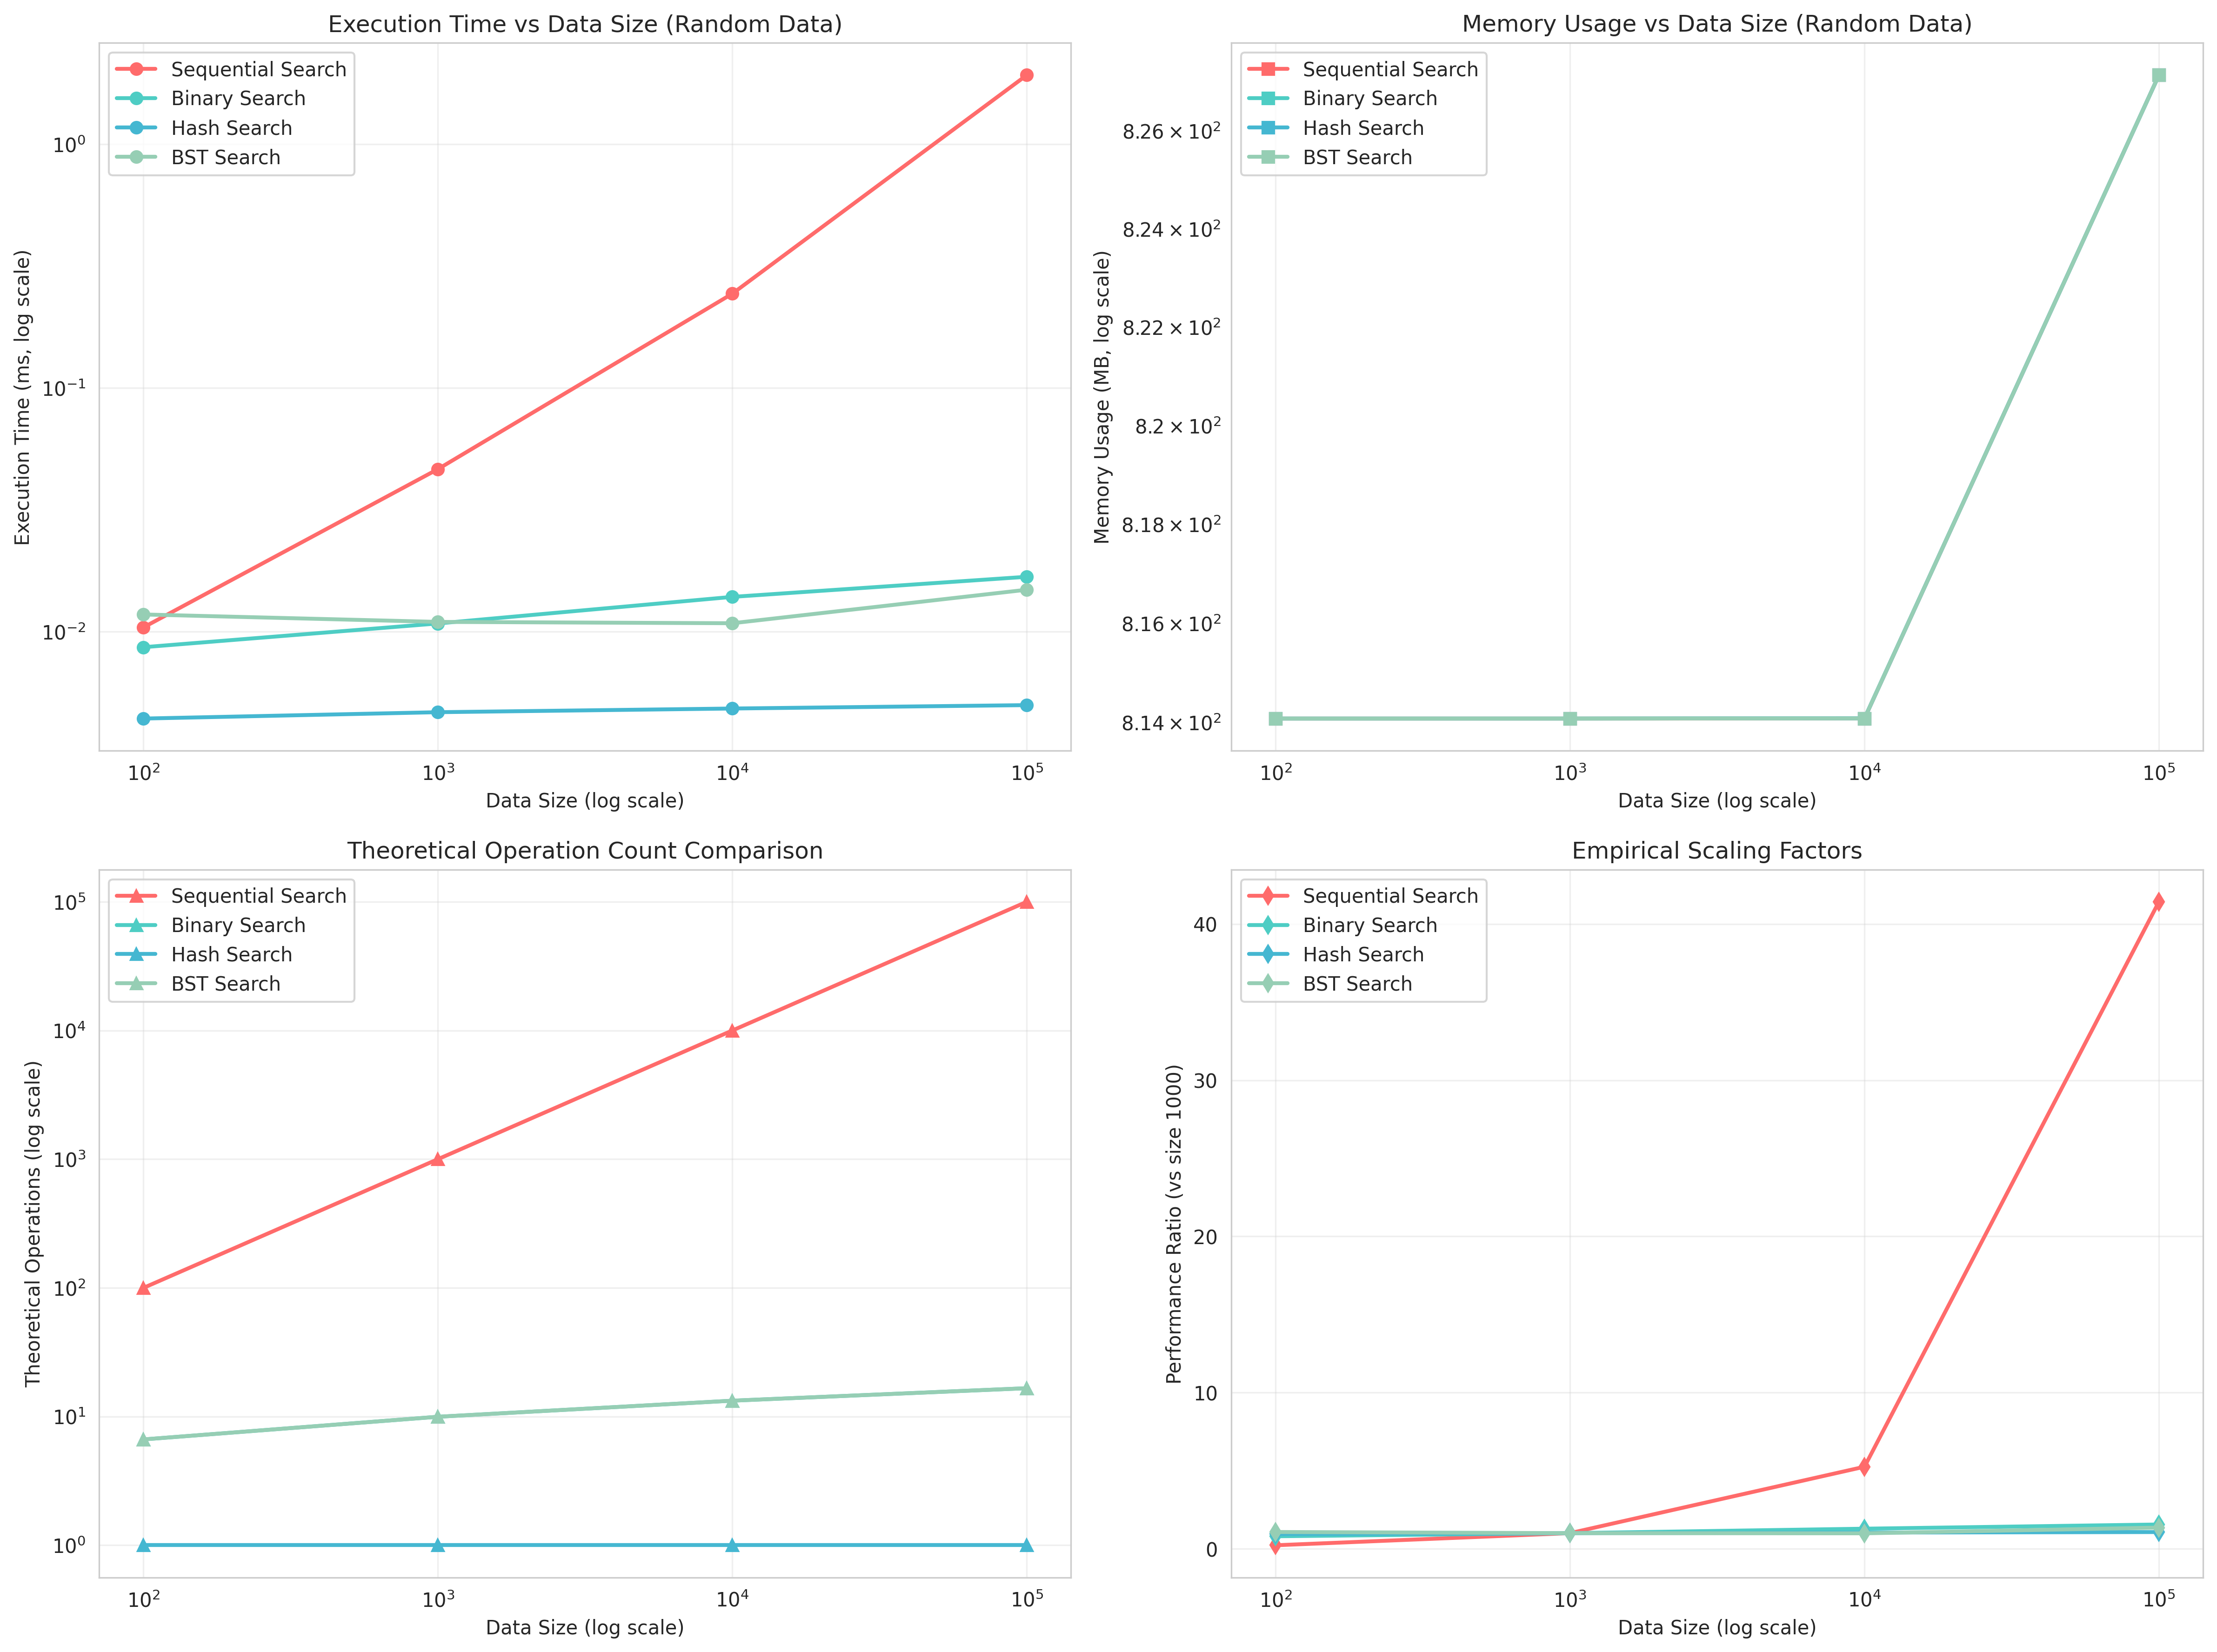


--- performance_by_data_type.png ---


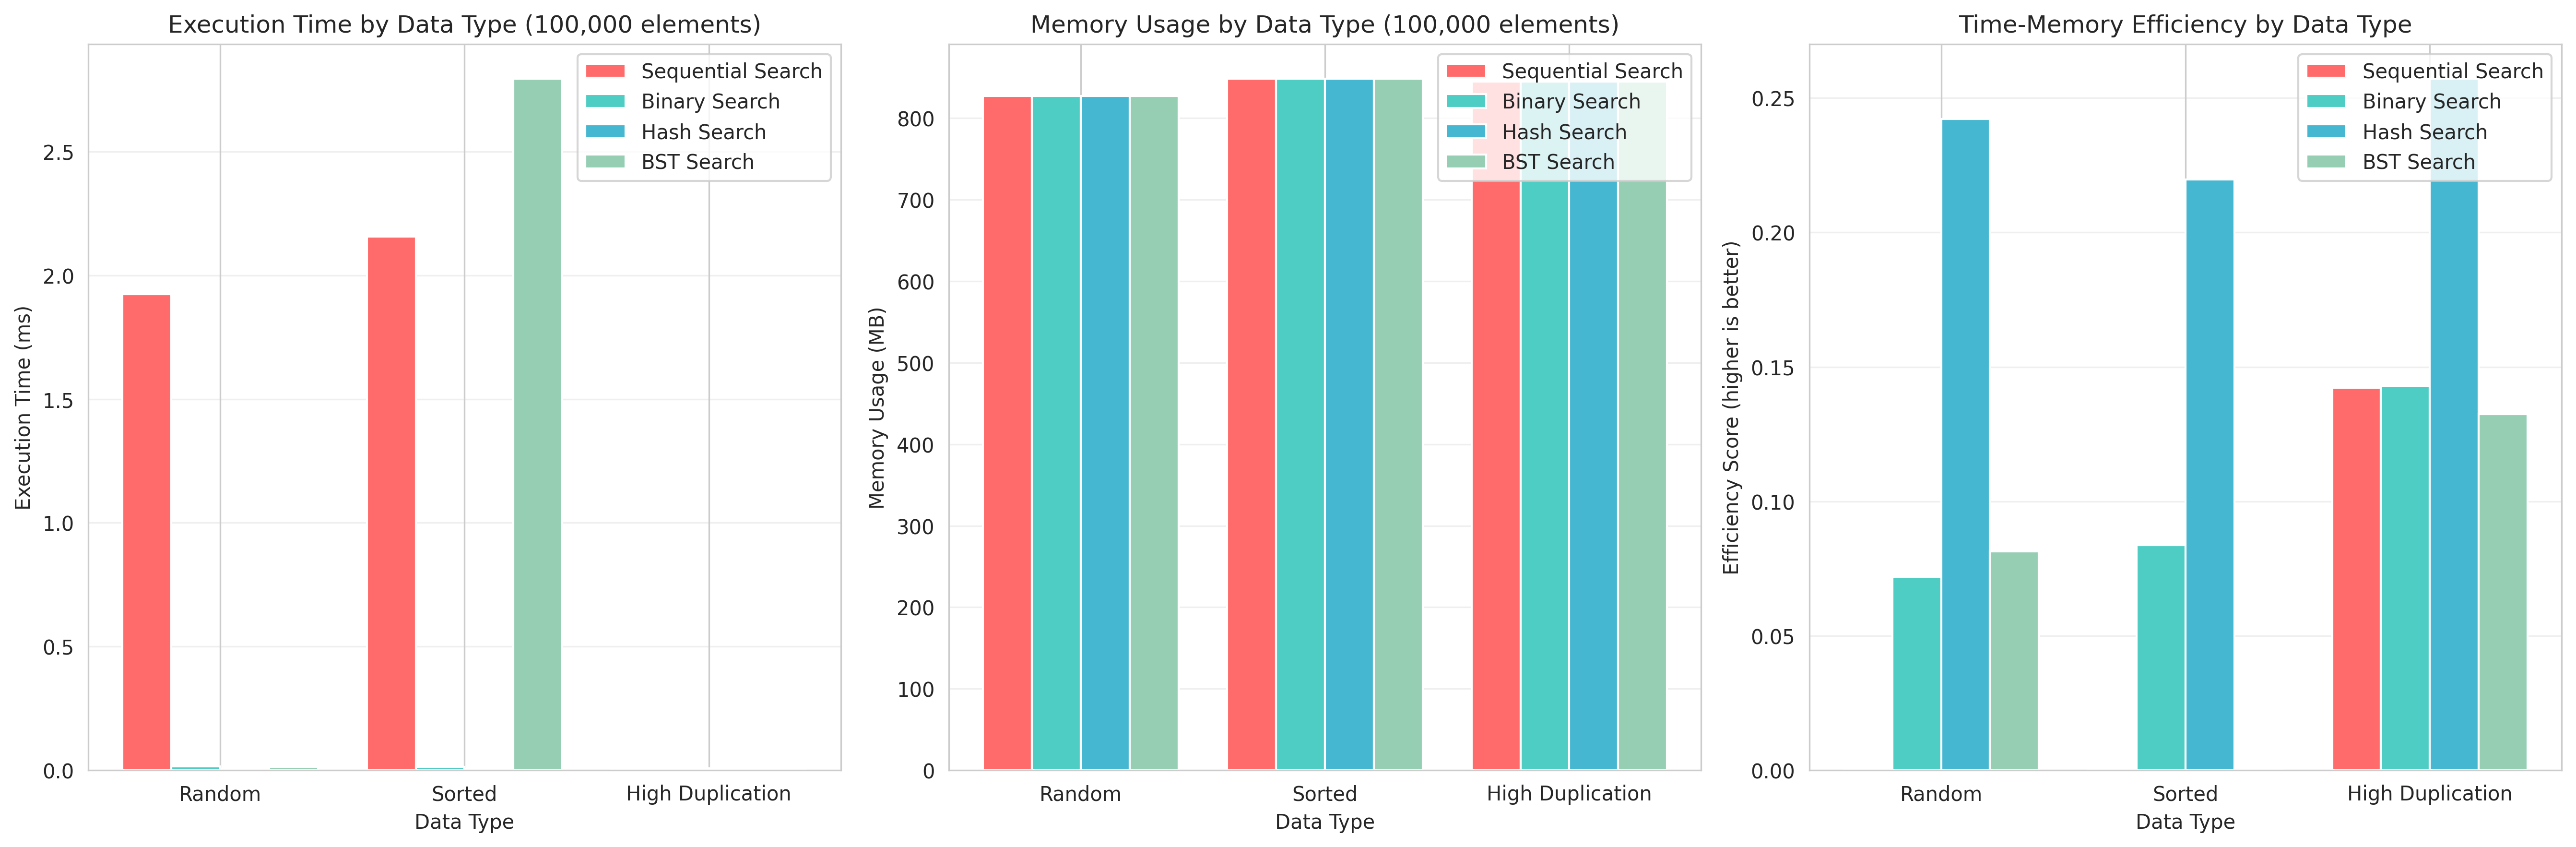


--- scaling_factors_analysis.png ---


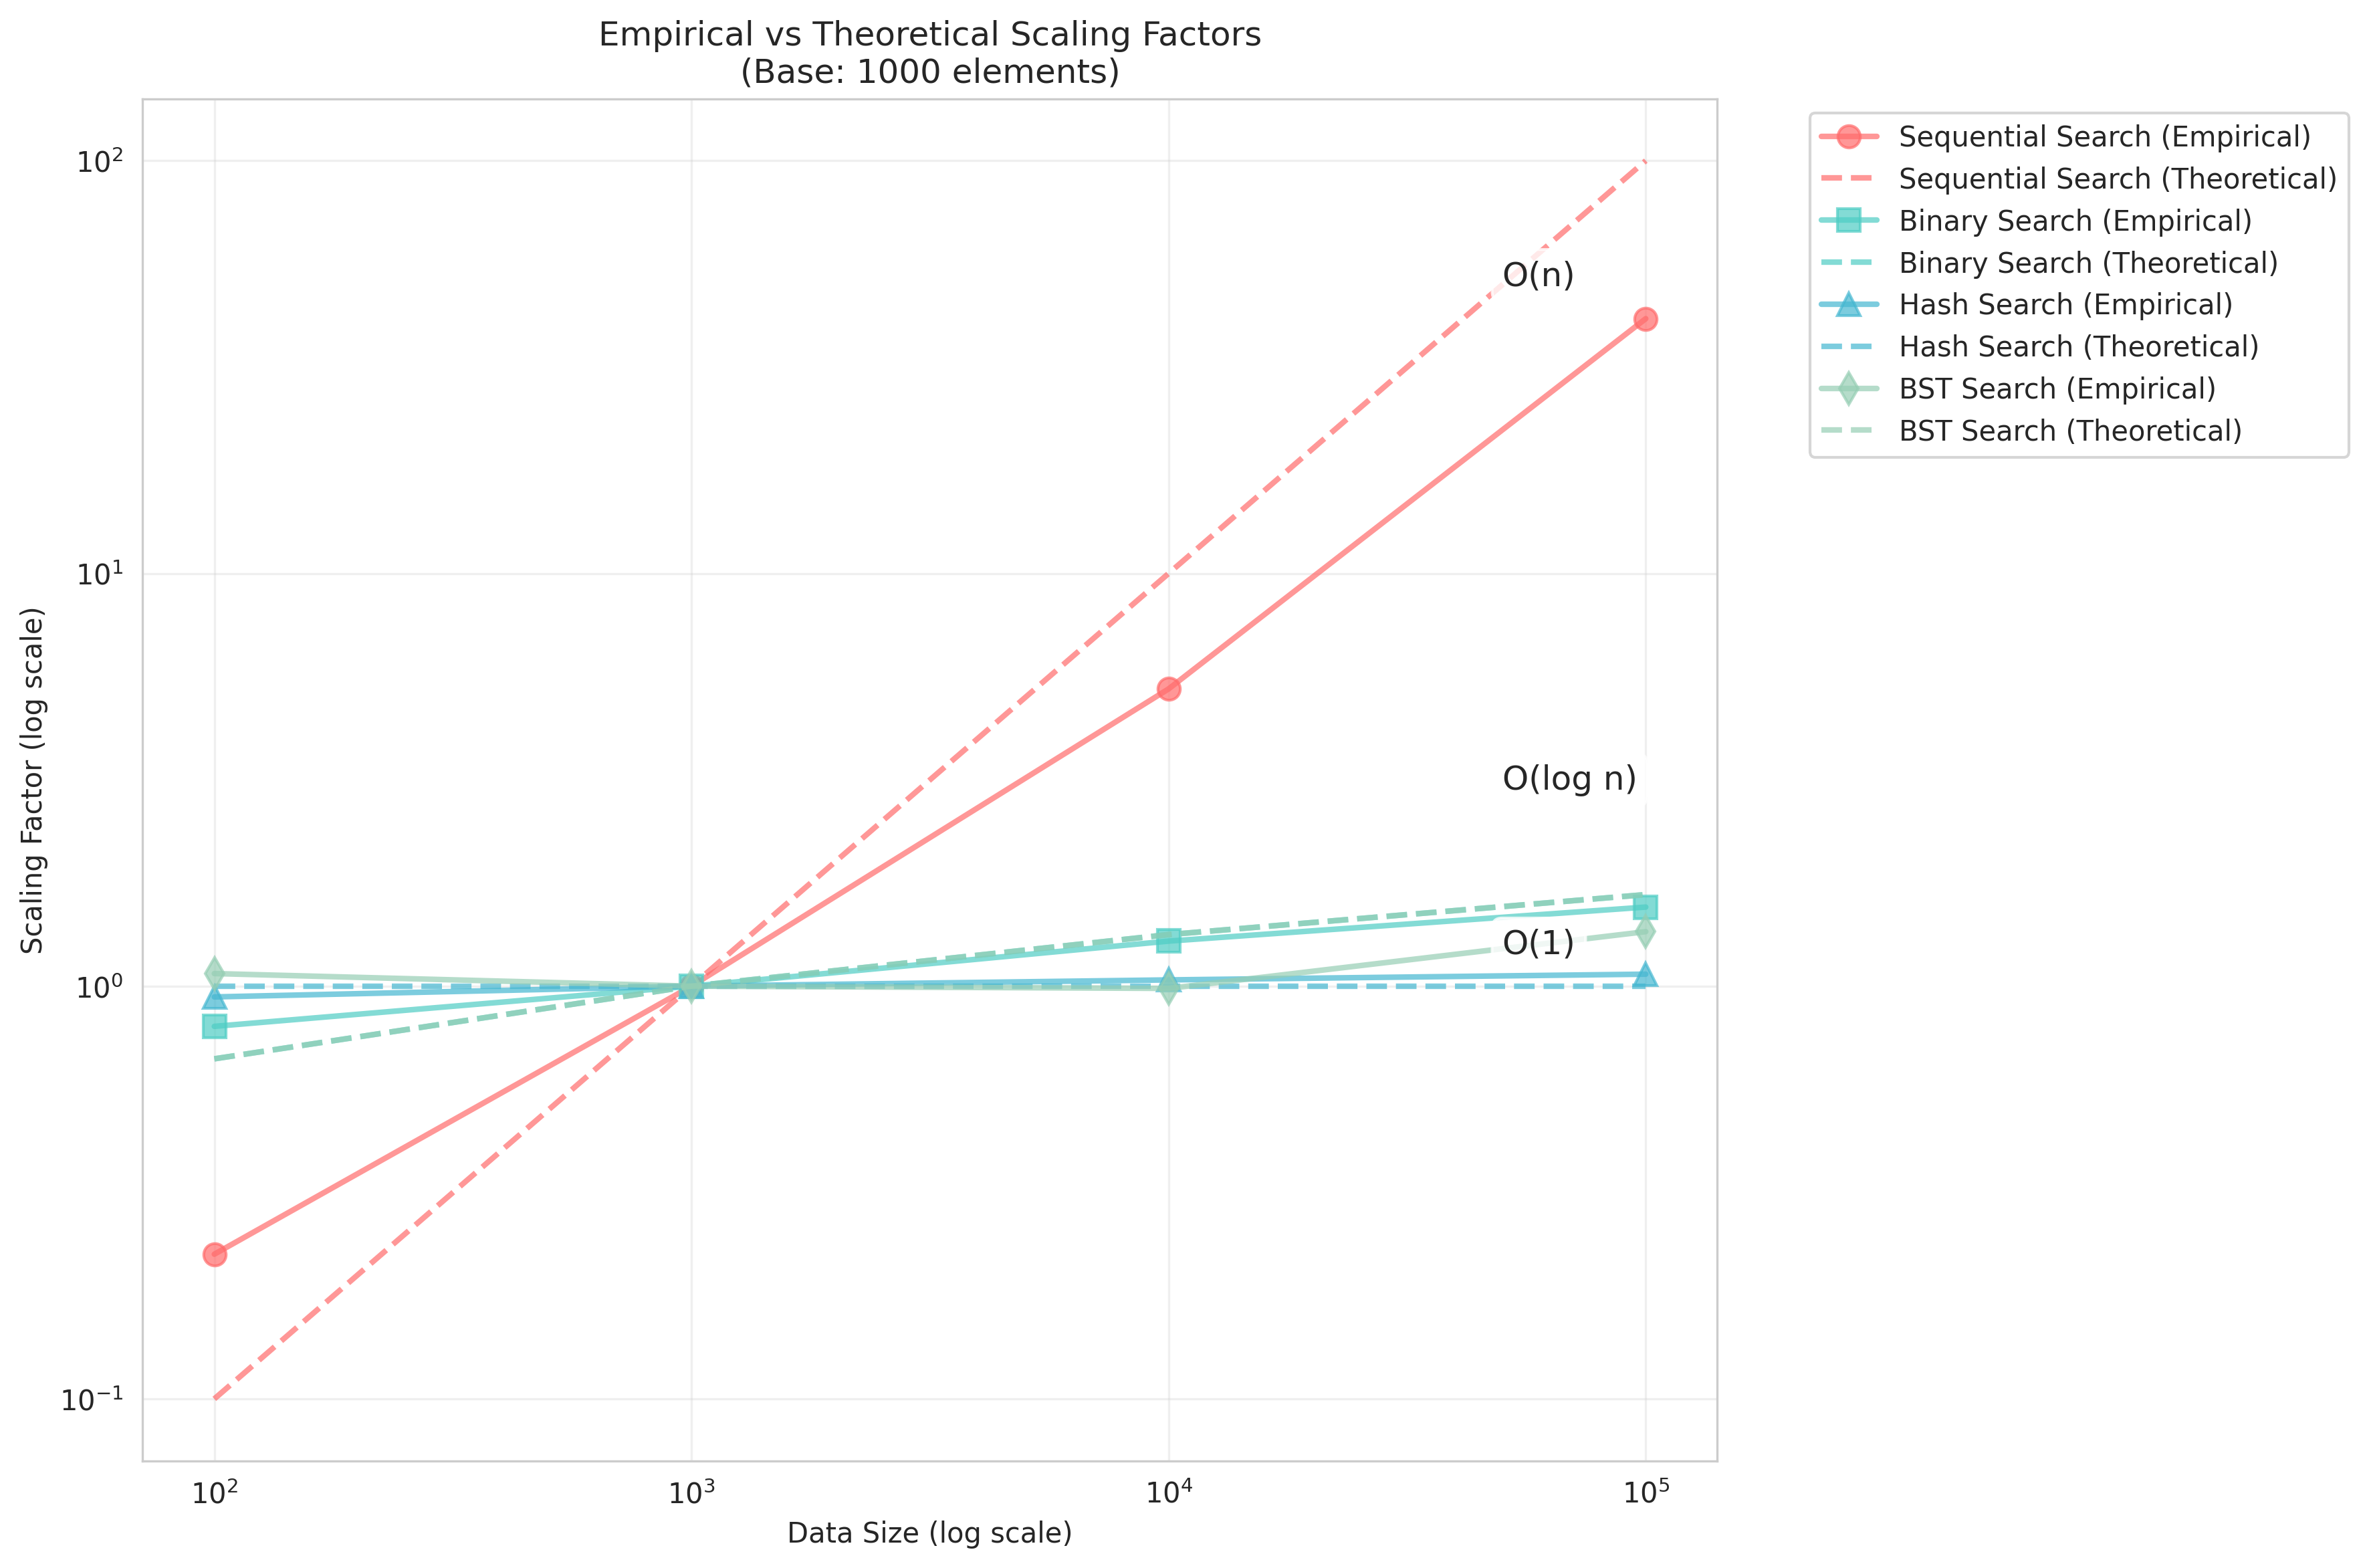

In [4]:
from IPython.display import Image, display

# List of generated image files (based on the output from the experiment)
image_files = [
    '/content/comprehensive_performance_analysis.png',
    '/content/performance_by_data_type.png',
    '/content/scaling_factors_analysis.png'
]

print("Displaying generated plots:")

for img_path in image_files:
    try:
        print(f"\n--- {img_path.split('/')[-1]} ---")
        display(Image(filename=img_path))
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
    except Exception as e:
        print(f"An error occurred while displaying {img_path}: {e}")